# Proyecto 1 - Grupo 9

## Integrantes
* Carol Sofía Florido Castro - 202111430
* Juan Martin Vasquez Cristancho - 202113314 
* Natalia Villegas Calderon - 202113370


## Objetivo

- Aplicar la metodología de analítica de textos para la construcción de soluciones de
analítica alineadas con los objetivos de organizaciones en un contexto de aplicación

## Contexto (eleccion de cliente: Faceboock)

Facebook ha identificado un creciente problema con la propagación de noticias falsas en su plataforma, lo que afecta su credibilidad y puede influir significativamente en la opinión pública, el desarrollo de eventos sociales y hasta en procesos electorales. A medida que la desinformación se propaga con rapidez a través de publicaciones, comentarios y enlaces compartidos, la plataforma ha recibido críticas por no actuar con suficiente rapidez para frenar la difusión de contenido engañoso. Conscientes de la necesidad de una solución efectiva, Facebook nos ha contactado para desarrollar un modelo de machine learning capaz de analizar, clasificar y filtrar noticias falsas antes de que estas alcancen una gran audiencia. Esta iniciativa busca reforzar la confianza en la plataforma, proteger a los usuarios de información manipulada y garantizar que el contenido que circula en el feed tenga un respaldo verificable. Además, la implementación de esta tecnología permitirá a Facebook mejorar sus sistemas de moderación de contenido, reducir el impacto de campañas de desinformación organizadas y proporcionar herramientas más eficientes a los verificadores de datos (fact-checkers) que trabajan en conjunto con la empresa.

# Limpieza de datos

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.stem import PorterStemmer

In [2]:
# librería Natural Language Toolkit, usada para trabajar con textos
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')
 # Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
nltk.download('stopwords')

#Descarga de paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabra
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Cargar datos
file_path = 'fake_news_spanish.csv'
df = pd.read_csv(file_path, delimiter=';', encoding='utf-8')


In [4]:
# Verificar la estructura del DataFrame
print("Información del DataFrame antes de la limpieza:")
display(df.info())
display(df.head())


Información del DataFrame antes de la limpieza:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           57063 non-null  object
 1   Label        57063 non-null  int64 
 2   Titulo       57047 non-null  object
 3   Descripcion  57063 non-null  object
 4   Fecha        57063 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


None

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


In [5]:
# Verificar valores nulos
print("Valores nulos por columna antes de la limpieza:")
display(df.isnull().sum())

Valores nulos por columna antes de la limpieza:


ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

Se puede overbar como a algunos datos les hace falta unicamente el titulo, lo cual es un problema menor.

In [6]:

# Verificar duplicados
print(f"Filas duplicadas antes de la limpieza: {df.duplicated().sum()}")


Filas duplicadas antes de la limpieza: 445


In [7]:
# Verificar valores únicos en la columna 'Label' con porcentajes
print("Valores únicos en 'Label' antes de la limpieza:")
label_counts = df['Label'].value_counts()
label_percentages = df['Label'].value_counts(normalize=True) * 100

# Crear un DataFrame con los valores absolutos y los porcentajes
porcentajes = pd.DataFrame({'Count': label_counts, 'Percentage': label_percentages})

# Mostrar el resultado
display(porcentajes)


Valores únicos en 'Label' antes de la limpieza:


,Count,Percentage
Label,,
1,33158,58.107706
0,23905,41.892294


Se puede observar como no hay un desvalance muy grande entre los labels ( noticias reales y noticias falsas) por lo tanto no habra necesidad de eliminar datos o crear datos sinteticos.

In [8]:
# 1. Eliminación de filas duplicadas
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f"Eliminando {duplicates} filas duplicadas...")
    df.drop_duplicates(inplace=True)

Eliminando 445 filas duplicadas...


In [9]:
# 2. Manejo de valores nulos en columnas esenciales
df.dropna(subset=['Label', 'Titulo', 'Descripcion', 'Fecha'], inplace=True)


In [10]:
# 3. Normalización de columnas: eliminar espacios extra
df.columns = df.columns.str.strip()


In [11]:
# 4. Asegurar que la columna Label solo tenga valores 0 o 1
df['Label'] = pd.to_numeric(df['Label'], errors='coerce')
df = df[df['Label'].isin([0, 1])]

In [12]:
# 5. Convertir la columna Fecha a formato datetime, manejando distintos formatos posibles
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, dayfirst=True, errors='coerce')
    except:
        return np.nan

df['Fecha'] = df['Fecha'].apply(parse_date)
df.dropna(subset=['Fecha'], inplace=True)

In [13]:

# 6. Limpiar texto de columnas de texto (Titulo y Descripcion)
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ0-9.,;:\"\'\s]', '', text)  # Eliminar caracteres extraños
        text = re.sub(r'\s+', ' ', text).strip()  # Espacios extra
    return text

df['Titulo'] = df['Titulo'].apply(clean_text)
df['Descripcion'] = df['Descripcion'].apply(clean_text)


In [14]:
# 7. Verificación final de valores nulos
display(df.isnull().sum())

ID             0
Label          0
Titulo         0
Descripcion    0
Fecha          0
dtype: int64

In [15]:
# Mostrar información final del DataFrame
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 56602 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           56602 non-null  object        
 1   Label        56602 non-null  int64         
 2   Titulo       56602 non-null  object        
 3   Descripcion  56602 non-null  object        
 4   Fecha        56602 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.6+ MB


None

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,2023-06-02
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,2023-10-01
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,2022-04-25
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",2022-01-03
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",2018-03-09


In [16]:
df_m = df.copy()

In [ ]:
import re
from nltk.tokenize import word_tokenize

##articulos = set(['la', 'el', 'los', 'las', 'un', 'una', 'unos', 'unas','y','que','por','en','que','del','como','para','de','con','se','lo','e','su','ejemplo','embargo','más'])

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    return [word.lower() for word in words]

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

#def remove_articles(words):
 #   """Remove articles from the list of tokenized words"""
  #  return [word for word in words if word not in articulos]
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    stop_words = set(stopwords.words('spanish'))
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return filtered_words



## NO CORRER !!

In [70]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

## NO CORRER ^^


In [18]:
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
df_m['completo'] = (df['Titulo'] + ' ' + df['Descripcion'])
df_m

,ID,Label,Titulo,Descripcion,Fecha,completo
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,2023-06-02,'The Guardian' va con Sánchez: 'Europa necesit...
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,2023-10-01,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,2022-04-25,El 'Ahora o nunca' de Joan Fuster sobre el est...
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",2022-01-03,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild..."
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",2018-03-09,Puigdemont: 'No sería ninguna tragedia una rep...
...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,2021-06-08,El Defensor del Pueblo reclama a la Comunidad ...
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,2020-09-08,El EQUO plantea ceder la presidencia de la Com...
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,2018-07-12,Alberto Garzón: 'Que los Borbones son unos lad...
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,2022-02-13,Vox exige entrar en el Gobierno de Castilla y ...


In [20]:
df_m['words'] = df_m['completo'].apply(word_tokenize)
df_m.head()

,ID,Label,Titulo,Descripcion,Fecha,completo,words
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,2023-06-02,'The Guardian' va con Sánchez: 'Europa necesit...,"['The, Guardian, ', va, con, Sánchez, :, 'Euro..."
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,2023-10-01,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,"[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE..."
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,2022-04-25,El 'Ahora o nunca' de Joan Fuster sobre el est...,"[El, 'Ahora, o, nunca, ', de, Joan, Fuster, so..."
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",2022-01-03,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","[Iglesias, alienta, a, Yolanda, Díaz, ,, ERC, ..."
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",2018-03-09,Puigdemont: 'No sería ninguna tragedia una rep...,"[Puigdemont, :, 'No, sería, ninguna, tragedia,..."


In [21]:
df_m['words1'] = df_m['words'].apply(preprocessing)

print(df_m.head())

   ID  Label                                             Titulo  \
0  ID      1  'The Guardian' va con Sánchez: 'Europa necesit...   
1  ID      0  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...   
2  ID      1  El 'Ahora o nunca' de Joan Fuster sobre el est...   
3  ID      1  Iglesias alienta a Yolanda Díaz, ERC y EH Bild...   
4  ID      0  Puigdemont: 'No sería ninguna tragedia una rep...   

                                         Descripcion      Fecha  \
0  El diario británico publicó este pasado jueves... 2023-06-02   
1  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ... 2023-10-01   
2  El valencianismo convoca en Castelló su fiesta... 2022-04-25   
3  En política, igual que hay que negociar con lo... 2022-01-03   
4  En una entrevista en El Punt Avui, el líder de... 2018-03-09   

                                            completo  \
0  'The Guardian' va con Sánchez: 'Europa necesit...   
1  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...   
2  El 'Ahora o nunca' de J

In [22]:
y_data_m = df_m['Label']
class_distribution = y_data_m.value_counts()
print("Distribución de clases:")
print(class_distribution)

Distribución de clases:
Label
1    32738
0    23864
Name: count, dtype: int64


**normalizacion**

In [23]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word, pos=wordnet.VERB) for word in words]
    return lemmatized_words

df_m['words1'] = df_m['words1'].apply(lemmatize_verbs)
df_m.head()

,ID,Label,Titulo,Descripcion,Fecha,completo,words,words1
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,2023-06-02,'The Guardian' va con Sánchez: 'Europa necesit...,"['The, Guardian, ', va, con, Sánchez, :, 'Euro...","[the, guardian, va, sánchez, europa, necesita,..."
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,2023-10-01,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,"[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE...","[revelan, gobierno, negocio, liberación, mirel..."
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,2022-04-25,El 'Ahora o nunca' de Joan Fuster sobre el est...,"[El, 'Ahora, o, nunca, ', de, Joan, Fuster, so...","[ahora, nunca, joan, fuster, estatuto, valenci..."
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",2022-01-03,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","[Iglesias, alienta, a, Yolanda, Díaz, ,, ERC, ...","[iglesias, alienta, yolanda, díaz, erc, eh, bi..."
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",2018-03-09,Puigdemont: 'No sería ninguna tragedia una rep...,"[Puigdemont, :, 'No, sería, ninguna, tragedia,...","[puigdemont, ninguna, tragedia, repetición, el..."


In [24]:
df_m['words1'] = df_m['words1'].apply(lambda x: ' '.join(map(str, x)))
df_m

,ID,Label,Titulo,Descripcion,Fecha,completo,words,words1
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,2023-06-02,'The Guardian' va con Sánchez: 'Europa necesit...,"['The, Guardian, ', va, con, Sánchez, :, 'Euro...",the guardian va sánchez europa necesita apuest...
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,2023-10-01,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,"[REVELAN, QUE, EL, GOBIERNO, NEGOCIO, LA, LIBE...",revelan gobierno negocio liberación mireles ca...
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,2022-04-25,El 'Ahora o nunca' de Joan Fuster sobre el est...,"[El, 'Ahora, o, nunca, ', de, Joan, Fuster, so...",ahora nunca joan fuster estatuto valenciano cu...
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",2022-01-03,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","[Iglesias, alienta, a, Yolanda, Díaz, ,, ERC, ...",iglesias alienta yolanda díaz erc eh bildu neg...
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",2018-03-09,Puigdemont: 'No sería ninguna tragedia una rep...,"[Puigdemont, :, 'No, sería, ninguna, tragedia,...",puigdemont ninguna tragedia repetición eleccio...
...,...,...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,2021-06-08,El Defensor del Pueblo reclama a la Comunidad ...,"[El, Defensor, del, Pueblo, reclama, a, la, Co...",defensor pueblo reclama comunidad madrid datos...
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,2020-09-08,El EQUO plantea ceder la presidencia de la Com...,"[El, EQUO, plantea, ceder, la, presidencia, de...",equo plantea ceder presidencia comunidad madri...
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,2018-07-12,Alberto Garzón: 'Que los Borbones son unos lad...,"[Alberto, Garzón, :, 'Que, los, Borbones, son,...",alberto garzón borbones ladrones hecho históri...
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,2022-02-13,Vox exige entrar en el Gobierno de Castilla y ...,"[Vox, exige, entrar, en, el, Gobierno, de, Cas...",vox exige entrar gobierno castilla león cara v...


In [25]:
X_data_m, y_data_m = df_m['words1'],df_m['Label']
y_data_m

0        1
1        0
2        1
3        1
4        0
        ..
57058    1
57059    0
57060    1
57061    1
57062    1
Name: Label, Length: 56602, dtype: int64

In [26]:
count = CountVectorizer()
X_count = count.fit_transform(df_m['words1'])
print(X_count.shape)
print(X_count.toarray()[0])

(56602, 51714)
[0 0 0 ... 0 0 0]


In [40]:
tf_idf_vectorizer = TfidfVectorizer()
X_tf_idf = tf_idf_vectorizer.fit_transform(df_m['words1'])
y_tf_idf = df_m['Label']
print(X_tf_idf.shape)  # Dimensiones de la matriz (número de documentos, número de términos)

print(X_tf_idf.toarray()[0])  

(56602, 51714)
[0. 0. 0. ... 0. 0. 0.]


In [29]:
print(df_m['words1'].head())

0    the guardian va sánchez europa necesita apuest...
1    revelan gobierno negocio liberación mireles ca...
2    ahora nunca joan fuster estatuto valenciano cu...
3    iglesias alienta yolanda díaz erc eh bildu neg...
4    puigdemont ninguna tragedia repetición eleccio...
Name: words1, dtype: object


In [30]:
label_values = ['1', '0']
for label in label_values:
    filtered_data = df_m[df_m['Label'] == label]
    print(f"Datos para label {label}:")
    print(filtered_data.head())
    print(f"Número de registros para label {label}: {filtered_data.shape[0]}")

Datos para label 1:
Empty DataFrame
Columns: [ID, Label, Titulo, Descripcion, Fecha, completo, words, words1]
Index: []
Número de registros para label 1: 0
Datos para label 0:
Empty DataFrame
Columns: [ID, Label, Titulo, Descripcion, Fecha, completo, words, words1]
Index: []
Número de registros para label 0: 0


## Exploracion de datos

C:\Users\marti\AppData\Local\Temp\ipykernel_15504\313128623.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Label'], palette='RdPu')


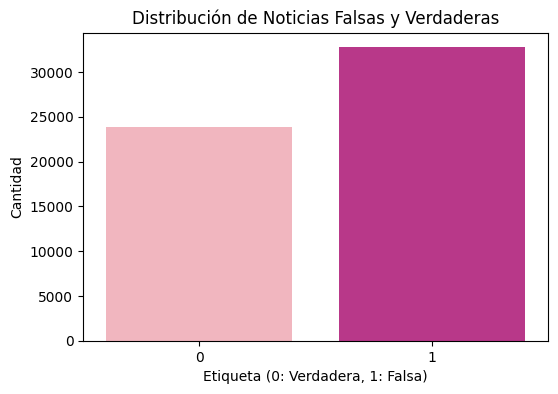

In [32]:
# Distribución de noticias falsas y verdaderas
plt.figure(figsize=(6,4))
sns.countplot(x=df['Label'], palette='RdPu')
plt.title('Distribución de Noticias Falsas y Verdaderas')
plt.xlabel('Etiqueta (0: Verdadera, 1: Falsa)')
plt.ylabel('Cantidad')
plt.show()

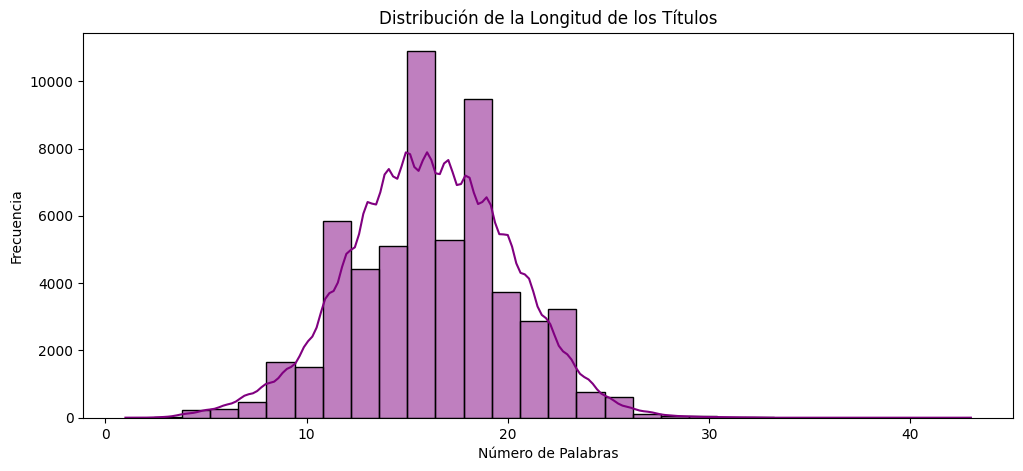

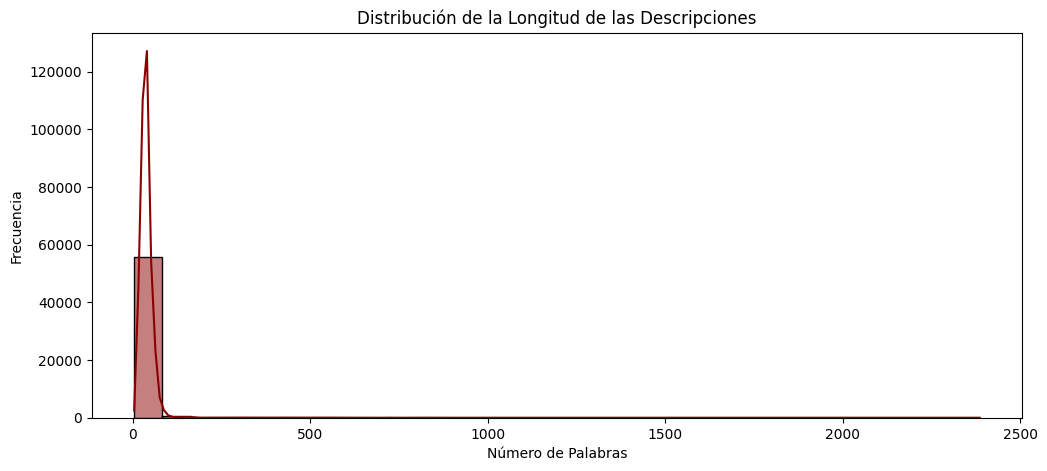

In [31]:
# Longitud del texto en títulos y descripciones
df['Titulo_Longitud'] = df['Titulo'].apply(lambda x: len(str(x).split()))
df['Descripcion_Longitud'] = df['Descripcion'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(12, 5))
sns.histplot(df['Titulo_Longitud'], bins=30, kde=True, color='purple')
plt.title('Distribución de la Longitud de los Títulos')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(df['Descripcion_Longitud'], bins=30, kde=True, color='darkred')
plt.title('Distribución de la Longitud de las Descripciones')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.show()


C:\Users\marti\AppData\Local\Temp\ipykernel_15504\2791150674.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Año'], palette='RdPu')


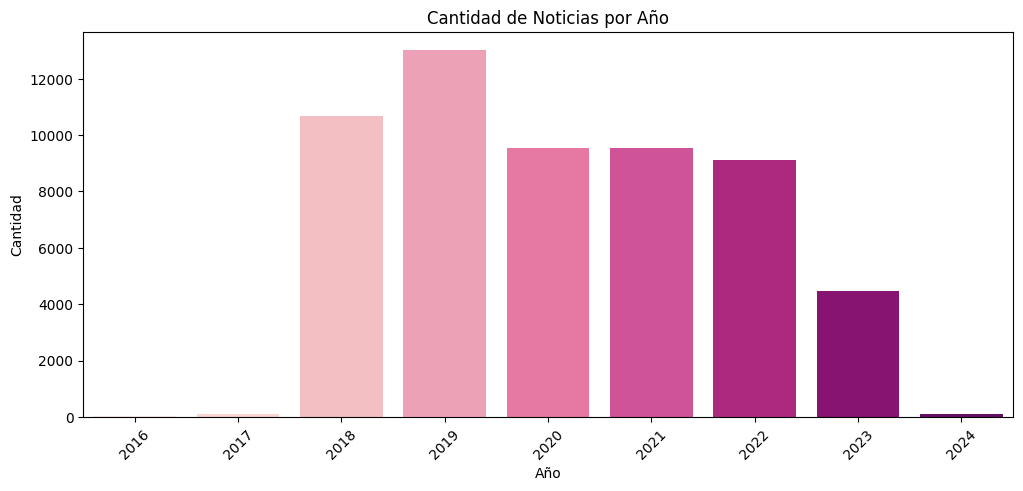

C:\Users\marti\AppData\Local\Temp\ipykernel_15504\2791150674.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Mes'], palette='RdPu')


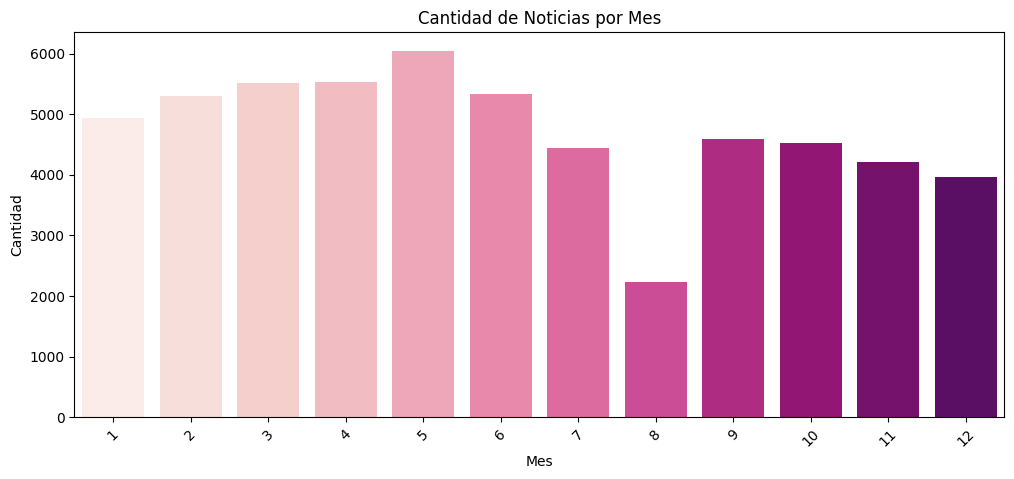

In [33]:
# Análisis de fechas
if pd.api.types.is_datetime64_any_dtype(df['Fecha']):
    df['Año'] = df['Fecha'].dt.year
    df['Mes'] = df['Fecha'].dt.month
    plt.figure(figsize=(12, 5))
    sns.countplot(x=df['Año'], palette='RdPu')
    plt.title('Cantidad de Noticias por Año')
    plt.xlabel('Año')
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(12, 5))
    sns.countplot(x=df['Mes'], palette='RdPu')
    plt.title('Cantidad de Noticias por Mes')
    plt.xlabel('Mes')
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)
    plt.show()


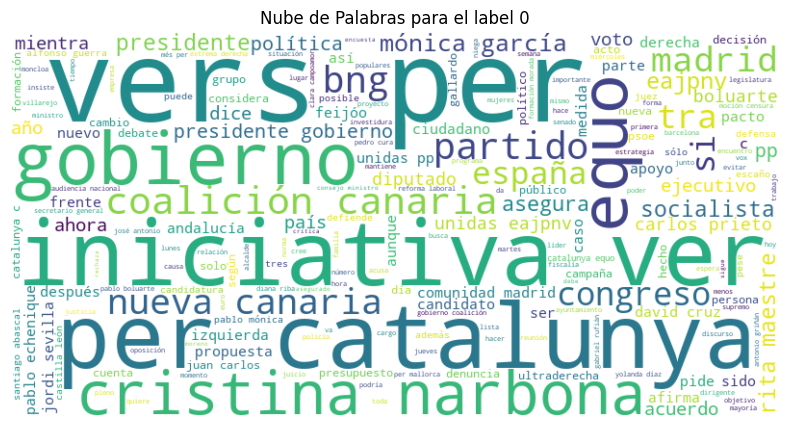

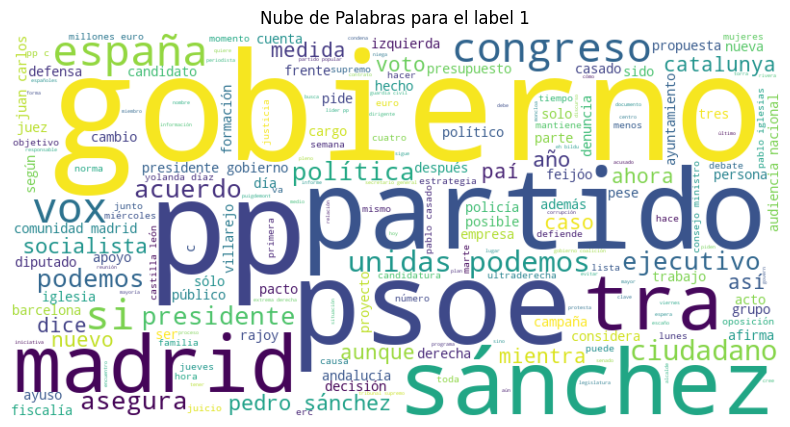

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for label in [0,1]:
    text_ = ' '.join(df_m[df_m['Label'] == label]['words1'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Nube de Palabras para el label {label}')
    plt.axis('off')
    plt.show()

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

def print_most_frequent_words(texts, n=10):
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(texts)
    words = vectorizer.get_feature_names_out()
    sums = X.sum(axis=0)
    word_freq = [(word, sums[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    df = pd.DataFrame(word_freq, columns=['Word', 'Frequency'])
    print(df.head(n))

for label in [0,1]:
    texts_ = df_m[df_m['Label'] == label]['words1']
    print(f"Palabras más frecuentes para label {label}:")
    print_most_frequent_words(texts_, n=10)
    print("\n")

Palabras más frecuentes para label 0:
         Word  Frequency
0    gobierno       8272
1   catalunya       6726
2  iniciativa       5900
3        vers       5550
4        equo       5254
5      madrid       3496
6     partido       3272
7  presidente       3203
8   coalición       3097
9         bng       2863


Palabras más frecuentes para label 1:
         Word  Frequency
0    gobierno       9941
1          pp       7804
2     podemos       4693
3     sánchez       4617
4        psoe       4594
5      madrid       4542
6     partido       3710
7  presidente       3695
8         vox       3340
9        tras       3324




## Modelos de Clasificacion

## 1. Random Forest

In [72]:
# Vectorización de texto
# Vectorización de texto
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Titulo'] + ' ' + df['Descripcion'])
y = df['Label']


In [73]:
# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [74]:
# Entrenar modelo Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [75]:
# Predicciones
y_pred = model.predict(X_test)



In [76]:
# Evaluación del modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
f2 = fbeta_score(y_test, y_pred, beta=2)
roc_auc = roc_auc_score(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("--- MÉTRICAS DEL MODELO ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"R2 Score: {r2:.4f}")


--- MÉTRICAS DEL MODELO ---
Accuracy: 0.9132
Precision: 0.9024
Recall: 0.9530
F1 Score: 0.9270
F2 Score: 0.9424
ROC AUC Score: 0.9058
R2 Score: 0.6439


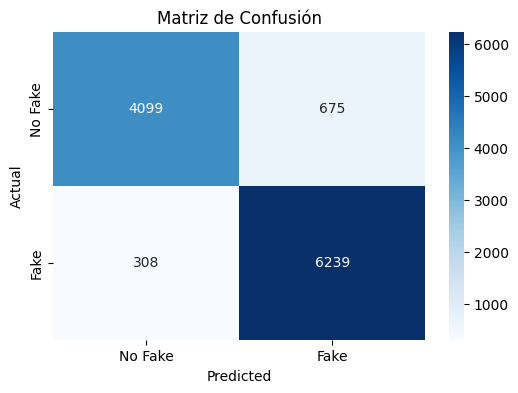

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, r2_score, confusion_matrix
import seaborn as sns
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fake', 'Fake'], yticklabels=['No Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()


## Seleccion de hiperparametros con Optuna

In [26]:
import optuna
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, fbeta_score, roc_auc_score, r2_score)
import warnings

# Ignorar warnings de métricas cuando hay clases no representadas en las predicciones
warnings.filterwarnings("ignore", category=UserWarning)

# Vectorización de texto
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Titulo'] + ' ' + df['Descripcion'])
y = df['Label']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Función objetivo para Optuna
def objective(trial):
    """Función objetivo para la optimización de hiperparámetros con Optuna."""
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Definir modelo
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1  # Paralelización
    )

    # Validación cruzada
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    return score  # Se optimiza F1-score

# Configuración de Optuna
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=100)  # Se aumentan las iteraciones

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("\n--- HIPERPARÁMETROS SELECCIONADOS ---")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Entrenar modelo final con mejores hiperparámetros
model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Evaluación del modelo
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred, zero_division=0),
    "F1 Score": f1_score(y_test, y_pred, zero_division=0),
    "F2 Score": fbeta_score(y_test, y_pred, beta=2, zero_division=0),
    "ROC AUC Score": roc_auc_score(y_test, y_pred),
    "R2 Score": r2_score(y_test, y_pred),
}

print("\n--- MÉTRICAS DEL MODELO OPTIMIZADO ---")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


[I 2025-02-19 16:36:58,356] A new study created in memory with name: no-name-4e99039a-db44-469f-a84f-fee251f37363
[I 2025-02-19 16:37:07,016] Trial 0 finished with value: 0.91565138483999 and parameters: {'n_estimators': 144, 'max_depth': 48, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.91565138483999.
[I 2025-02-19 16:37:09,354] Trial 1 finished with value: 0.8413882950691101 and parameters: {'n_estimators': 89, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.91565138483999.
[I 2025-02-19 16:37:17,869] Trial 2 finished with value: 0.9074553835196728 and parameters: {'n_estimators': 200, 'max_depth': 37, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.91565138483999.
[I 2025-02-19 16:37:22,832] Trial 3 finished with value: 0.8561436317969735 and parameters: {'n_estimators': 258, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.91565


--- HIPERPARÁMETROS SELECCIONADOS ---
n_estimators: 300
max_depth: 49
min_samples_split: 2
min_samples_leaf: 1

--- MÉTRICAS DEL MODELO OPTIMIZADO ---
Accuracy: 0.9006
Precision: 0.8613
Recall: 0.9872
F1 Score: 0.9199
F2 Score: 0.9591
ROC AUC Score: 0.8846
R2 Score: 0.5925


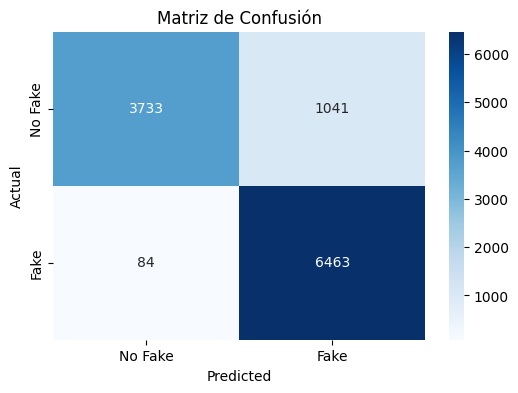

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, r2_score, confusion_matrix
import seaborn as sns
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Fake', 'Fake'], yticklabels=['No Fake', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()


In [29]:

import joblib

# Guardar el modelo entrenado
joblib.dump(model, "modelo_random_forest_Optuna.pkl")


['modelo_random_forest_Optuna.pkl']

## KNN

In [41]:
X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN = train_test_split(X_tf_idf, y_tf_idf, test_size=0.2, random_state=42)

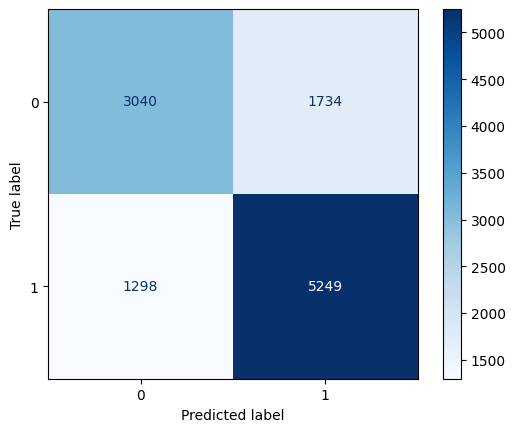

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

knn = KNeighborsClassifier()
knn.fit(X_train_KNN, y_train_KNN)
# Hacer predicciones
y_pred_KNN = knn.predict(X_test_KNN)

# Generar la matriz de confusión
cm = confusion_matrix(y_test_KNN, y_pred_KNN)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [44]:
# Evaluación del modelo
accuracy = accuracy_score(y_test_KNN, y_pred_KNN)
precision = precision_score(y_test_KNN, y_pred_KNN)
recall = recall_score(y_test_KNN, y_pred_KNN)
f1 = f1_score(y_test_KNN, y_pred_KNN)
f2 = fbeta_score(y_test_KNN, y_pred_KNN, beta=2)
roc_auc = roc_auc_score(y_test_KNN, y_pred_KNN)
r2 = r2_score(y_test_KNN, y_pred_KNN)

print("--- MÉTRICAS DEL MODELO ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"R2 Score: {r2:.4f}")

--- MÉTRICAS DEL MODELO ---
Accuracy: 0.7322
Precision: 0.7517
Recall: 0.8017
F1 Score: 0.7759
F2 Score: 0.7912
ROC AUC Score: 0.7193
R2 Score: -0.0982
